# Projeto Final
## Nanodegree Engenheiro de Machine Learning

Neste projeto vamos treinar um algoritmo para classificar acordes de acordo com sua nota fundamental. Trabalharemos com áudios no formato `wav` e usaremos a biblioteca [LibROSA](http://librosa.github.io/librosa/) para extrair deles alguns atributos.

Para mais detalhes sobre o projeto, leia o relatório que encontra-se no mesmo diretório deste notebook.

### Carregando o conjunto de dados
Os acordes gravados em arquivos `wav` estão na pasta `code/data`. Vamos criar uma função que retorna dois arrays, um com o caminho para cada acorde e outro com a respectiva nota fundamental.


In [1]:
# Todos os imports

import glob

import numpy as np
import sklearn
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from pprint import pprint

/Users/marcosatanaka/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/marcosatanaka/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Montando arrays com o path de cada acorde e sua respectiva nota fundamental:

In [2]:
def get_chord_paths_and_labels():
    x = []
    y = []

    for file_name in glob.glob1("code/data", "*.wav"):
        x.append("code/data/" + file_name)
        y.append(file_name[0])
    
    return x, y

Teste e visualização do que foi lido:

In [3]:
x_all, y_all = get_chord_paths_and_labels()

print "Encontrados {} arquivos no conjunto de dados.\n".format(len(x_all))

print "Primeiros 5 arquivos:"
pprint(x_all[:5])

print "\nPrimeiros 5 labels:"
pprint(y_all[:5])

Encontrados 106 arquivos no conjunto de dados.

Primeiros 5 arquivos:
['code/data/A.wav',
 'code/data/A6.wav',
 'code/data/A7.wav',
 'code/data/A7sus4.wav',
 'code/data/A7sus4_2.wav']

Primeiros 5 labels:
['A', 'A', 'A', 'A', 'A']


### Extraindo os atributos
Agora criaremos uma função para extrair os atributos que servirão de entrada para os algoritmos. A biblioteca LibROSA, carrega o arquivo `wav` e extrai o chromagrama.

Obtemos um array com 12 posições. Em cada posição há outro array, que contém o chroma daquele áudio em vários instantes de tempo (conforme seu `sample_rate`):

In [4]:
def get_chroma(sound_path):
    audio_time_series, sample_rate = librosa.load(sound_path)
    stft = np.abs(librosa.stft(audio_time_series))

    # chroma_stft: retorna a quantidade de cada chroma a cada frame
    # [00] 0.3, 0.3, 0.4
    # [01] 0.7, 0.7, 0.6
    # ...
    # [12] 0.0, 0.0, 0.0
    #
    # fazemos transpose e media para obter a media de cada chroma
    # [00] 0.3
    # [01] 0.6
    # ...
    # [12] 0.0
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

Calculamos a média de cada array para obter a ocorrência média de cada nota naquele acorde. O resultado final é um array com 12 posições, uma para cada nota, cujo valor é o percentual de presença daquela nota no acorde.

Veja abaixo, um exemplo do chromagrama do acorde E6 deste conjunto de dados:

In [5]:
e6_chroma = get_chroma(x_all[57])
notes = ['C ', 'C#', 'D ', 'D#', 'E ', 'F ', 'F#', 'G ', 'G#', 'A ', 'A#', 'B ']

for i, chroma in enumerate(e6_chroma):
    print "{}: {:.2f}".format(notes[i], chroma)

C : 0.15
C#: 0.19
D : 0.10
D#: 0.36
E : 0.95
F : 0.34
F#: 0.07
G : 0.16
G#: 0.44
A : 0.14
A#: 0.18
B : 0.45


Utilizando a função anterior, implementamos outra para extrair o chroma de todos os acordes lidos e retornar tudo em um array. Este array contém todos os  atributos que serão utilizados para treinar os algoritmos:

In [6]:
def get_features(sounds_paths):
    features = np.empty((0, 12))

    for sound_path in sounds_paths:
        try:
            chroma = get_chroma(sound_path)
        except Exception as e:
            print "Error encountered while parsing file: ", sound_path
            raise

        ext_features = np.hstack([chroma])
        features = np.vstack([features, ext_features])

    return np.array(features)

### Visualizando os dados
Vamos criar algumas funções auxiliares para nos ajudar a visualizar os dados.

Primeiro vamos visualizar a forma de onda dos acordes no nosso conjunto de dados:

In [7]:
def plot_wave(sound_path):
    plt.figure(figsize=(15, 4), dpi=300)
    audio_time_series, sample_rate = librosa.load(sound_path)
    librosa.display.waveplot(np.array(audio_time_series), sr=22050)
    plt.title(sound_path)
    plt.show()

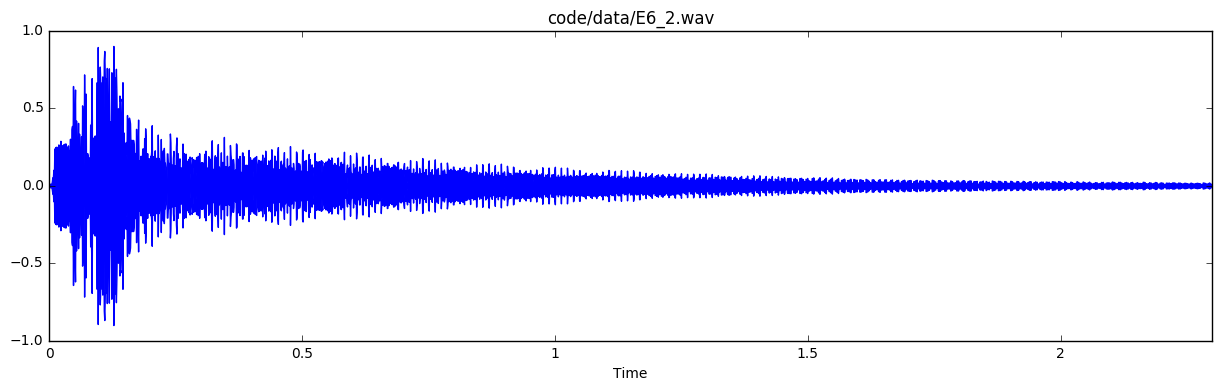

In [8]:
plot_wave(x_all[57])

Agora, vamos visualizar o chromagrama:

In [9]:
def plot_chromagram(sound_path):
    plt.figure(figsize=(15, 4), dpi=300)
    audio_time_series, sample_rate = librosa.load(sound_path)
    stft = np.abs(librosa.stft(audio_time_series))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(sound_path)
    plt.show()

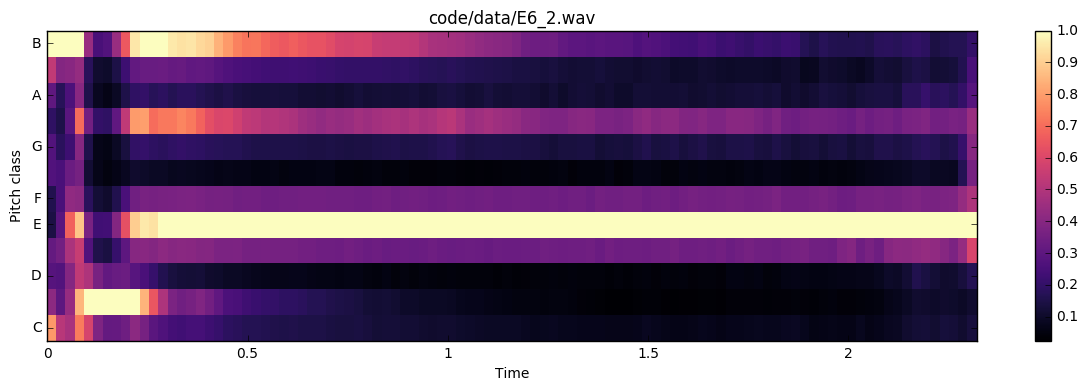

In [10]:
plot_chromagram(x_all[57])

### Treinando e testando os algoritmos

Temos agora que instanciar, treinar e testar os algoritmos escolhidos.

Mas antes, vamos escrever uma função para encontrar os melhores hiper-parâmetros de alguns deles:

In [11]:
def best_estimator(clf, parameters, x_train, y_train):
    scorer = make_scorer(accuracy_score)

    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    grid_obj = grid_obj.fit(x_train, y_train)

    print "Melhores parametros: {}".format(grid_obj.best_params_)

    # Get the estimator
    return grid_obj.best_estimator_

Agora uma função responsável por instanciar os algoritmos escolhidos, otimizar seus parâmetros, treiná-los e testá-los.

Foram comparados os algoritmos SVM, Gaussian Naive Bays, Decision Tree e Ada Boost. O primeiro e o terceiro tiveram seus hiper-parâmetros escolhidos utilizando GridSearch.

O treinamento e teste foi feito utilizando validação cruzada.

In [12]:
def cross_validation_score(x_all, y_all, n_cv):
    # SVM
    clf = SVC(random_state=1)
    parameters = [
        {'kernel': ['linear'], 'C': np.arange(0.1, 1, 0.1)},
        {'kernel': ['rbf'], 'C': np.arange(0.1, 1, 0.1), 'gamma': np.arange(0.1, 1, 0.1)},
        {'kernel': ['sigmoid'], 'C': np.arange(0.1, 1, 0.1), 'gamma': np.arange(0.1, 1, 0.1),
         'coef0': [0, 1, 2, 3, 4, 5]}
    ]
    clf = best_estimator(clf, parameters, x_all, y_all)

    scores = cross_val_score(clf, x_all, y_all, cv=n_cv, scoring="accuracy")

    print "Acurácia SVC ({}-Fold): {:.2f}\n".format(n_cv, scores.mean())

    # GaussianNB
    scores = cross_val_score(GaussianNB(), x_all, y_all, cv=n_cv, scoring="accuracy")
    print "Acurácia GNB ({}-Fold): {:.2f}\n".format(n_cv, scores.mean())

    # DecisionTree
    clf = DecisionTreeClassifier(random_state=1)
    parameters = [
        {'max_depth': np.arange(2, 10, 1)}
    ]
    clf = best_estimator(clf, parameters, x_all, y_all)
    scores = cross_val_score(clf, x_all, y_all, cv=n_cv, scoring="accuracy")
    print "Acurácia DTC ({}-Fold): {:.2f}\n".format(n_cv, scores.mean())

    # AdaBoost
    scores = cross_val_score(AdaBoostClassifier(random_state=1), x_all, y_all, cv=n_cv, scoring="accuracy")
    print "Acurácia ABC ({}-Fold): {:.2f}\n".format(n_cv, scores.mean())

### Conferindo o resultado
Escrevemos todas as funções necessárias para o projeto. Vamos testar e ver o resultado:

In [13]:
x_all, y_all = get_chord_paths_and_labels()

x_all = get_features(x_all)
cross_validation_score(x_all, y_all, 9)

Melhores parametros: {'kernel': 'linear', 'C': 0.90000000000000002}
Acurácia SVC (9-Fold): 0.63

Acurácia GNB (9-Fold): 0.51

Melhores parametros: {'max_depth': 4}
Acurácia DTC (9-Fold): 0.49

Acurácia ABC (9-Fold): 0.34



SVM foi o modelo que obteve maior acurácia.

A quantidade de subconjuntos utilizados na validação cruzada (9) foi definida ao percorrer um laço, de dois a doze, e comparar a acurácia obtida em cada iteração.